# HL02 - smooth hydraulic level

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import stripy
import pandas as pd
%matplotlib inline

extent_globe = [-180,180,-90,90]
extent_australia = [110, 158, -44, -8]

In [2]:
gw_lon, gw_lat, gw_level, gw_level_std = np.loadtxt('../Data/NGIS_groundwater_levels_AUS.csv',
                                         delimiter=',', usecols=(2,3,8,9), skiprows=1, unpack=True)

gw_lonlat = np.column_stack([gw_lon, gw_lat])

## Setup mesh

In [3]:
# remove duplicate coordinates
unique_gw_lonlat, uindex = np.unique(np.radians(gw_lonlat.astype(np.float32)), return_index=True, axis=0)
unique_gw_level = gw_level[uindex]


# Find some respectable subset of points to use for gridding / heat-map 

# stripy mesh
mesh = stripy.sTriangulation(unique_gw_lonlat[:,0], unique_gw_lonlat[:,1], permute=True)

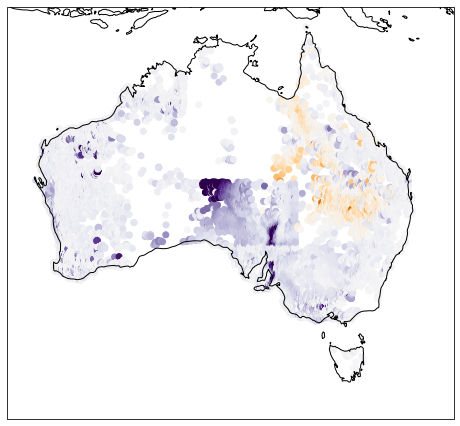

In [4]:
proj = ccrs.Mercator(central_longitude=160)


fig = plt.figure(figsize=(8,10))

ax = plt.axes(projection=proj)
ax.set_extent(extent_australia)
ax.coastlines()

vmax = np.percentile(np.abs(gw_level), 99)
vmin = -vmax

sc = ax.scatter(np.degrees(mesh.lons), np.degrees(mesh.lats), c=unique_gw_level, cmap='PuOr', vmin=vmin, vmax=vmax,
                transform=ccrs.PlateCarree())

In [26]:
## Define starting grid

grid1r = stripy.spherical_meshes.icosahedral_mesh(include_face_points=True, refinement_levels=7, tree=False)

## Drop points outside the region of interest  (Uluru - lat: -25.344428 lon: 131.036882.)

angles = grid1r.angular_separation( grid1r.lons, grid1r.lats, np.radians(131.1) * np.ones_like(grid1r.lons), 
                                   np.radians(-25.3) * np.ones_like(grid1r.lats) ) 

nodes = np.where(angles < np.radians(25.0))
grid1 = stripy.sTriangulation(grid1r.lons_map_to_wrapped(grid1r.lons[nodes])%(2.0*np.pi), grid1r.lats[nodes], permute=False)

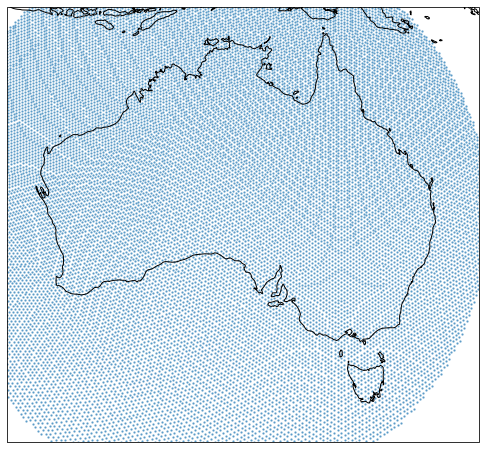

In [27]:
proj = ccrs.Mercator(central_longitude=130)

fig = plt.figure(figsize=(12,8))

ax = plt.axes(projection=proj)
ax.set_extent(extent_australia)
ax.coastlines()

vmax = np.percentile(np.abs(gw_level), 99)
vmin = -vmax

sc = ax.scatter(np.degrees(grid1.lons), np.degrees(grid1.lats), vmin=vmin, vmax=vmax, alpha=0.5, s=2.0,
                transform=ccrs.PlateCarree())

In [28]:
def weighted_average_to_nodes(lons, lats, data, interpolator ):
    
    grid   = np.zeros(interpolator.npoints)
    norm   = np.zeros(interpolator.npoints)
    count  = np.zeros(interpolator.npoints, dtype=np.int)

    bcc, nodes = interpolator.containing_simplex_and_bcc(lons, lats)

    # Beware vectorising the reduction operation !!
    
    for i in range(0, len(data)):
        
        grid[nodes[i][0]] += bcc[i][0] * data[i]
        grid[nodes[i][1]] += bcc[i][1] * data[i]
        grid[nodes[i][2]] += bcc[i][2] * data[i]

        norm[nodes[i][0]] += bcc[i][0]
        norm[nodes[i][1]] += bcc[i][1]
        norm[nodes[i][2]] += bcc[i][2]
        
        count[nodes[i][0]] += 1
        count[nodes[i][1]] += 1
        count[nodes[i][2]] += 1
        

    grid[np.where(norm > 1.0e-18)] /= norm[np.where(norm > 1.0e-18)]
    norm[np.where(norm <=1.0e-18)] = 0.0

    
    return grid, norm, count

In [29]:
ave, norm, count = weighted_average_to_nodes(mesh.lons, mesh.lats, unique_gw_level, grid1)

In [30]:
sigma = grid1.get_spline_tension_factors(ave, tol=1e-2, grad=None)
gsmooth, deriv, err  = grid1.smoothing(ave, 1.0+norm, 1.0e3*(ave**2).mean(), 0.5, 0.001, sigma)
print("Err - ", err)

gsmooth1, deriv, err = grid1.smoothing(ave, 1.0+norm, 1.0e5*(ave**2).mean(), 0.5, 0.001, sigma)
print("Err - ", err)

Err -  0
Err -  0


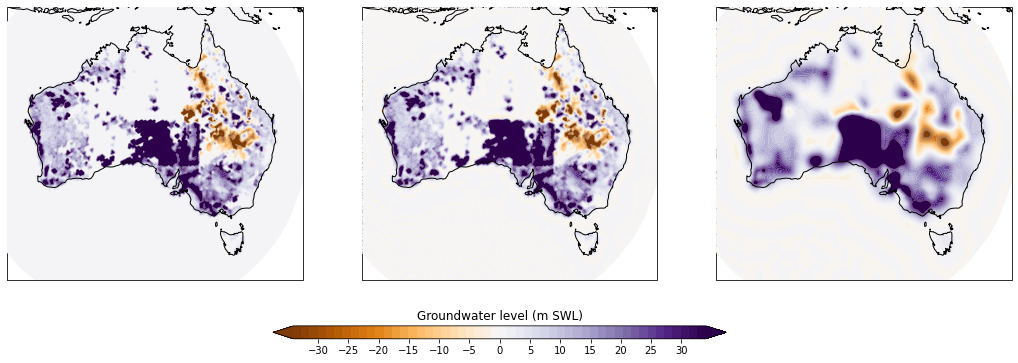

In [42]:
proj = ccrs.Mercator(central_longitude=130)

fig = plt.figure(figsize=(18,6))

ax = plt.subplot(131, projection=proj)
ax.set_extent(extent_australia)
ax.coastlines(zorder=100)

vmax = np.percentile(np.abs(ave), 95)
vmin = -vmax

grid_id = 4

goodgrid = grid1
data = ave
lons = goodgrid.lons
lats = goodgrid.lats

cnt0=ax.tricontourf(np.degrees(lons), np.degrees(lats), goodgrid.simplices, data, 
                   cmap="PuOr", 
                   levels=np.linspace(vmin, vmax, 51),
                   transform=ccrs.PlateCarree(),
                    extend="both",
                         antialiased=True,
                         alpha=1.0,
                         zorder=12)


ax2 = plt.subplot(132, projection=proj)
ax2.set_extent(extent_australia)
ax2.coastlines(zorder=100)

cnt2=ax2.tricontourf(np.degrees(lons), np.degrees(lats), goodgrid.simplices, gsmooth, 
                   cmap="PuOr", 
                   levels=np.linspace(vmin, vmax, 51),
                   transform=ccrs.PlateCarree(),
                    extend="both",
                         antialiased=True,
                         alpha=1.0,
                         zorder=12)


ax2 = plt.subplot(133, projection=proj)
ax2.set_extent(extent_australia)
ax2.coastlines(zorder=100)

cnt2=ax2.tricontourf(np.degrees(lons), np.degrees(lats), goodgrid.simplices, gsmooth1, 
                   cmap="PuOr", 
                   levels=np.linspace(vmin, vmax, 51),
                   transform=ccrs.PlateCarree(),
                    extend="both",
                         antialiased=True,
                         alpha=1.0,
                         zorder=12)

cax = plt.axes([0.33, 0.05, 0.35, 0.03], title='Groundwater level (m SWL)')
fig.colorbar(cnt2, cax=cax, orientation='horizontal', ticks=np.arange(-30,35,5))

fig.savefig("smooth_hydraulic_levels.png", bbox_inches='tight', dpi=600)